In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

In [4]:
radiomics_path = 'Exp_radiomics_features.csv'
rna_seq_path = 'Exp_rna_seq_data.csv'

In [5]:
radiomics_df = pd.read_csv(radiomics_path)
rna_seq_df = pd.read_csv(rna_seq_path)

In [6]:
combined_df = pd.merge(radiomics_df, rna_seq_df, on='patient_id')

In [7]:
combined_df.fillna(method='ffill', inplace=True)

In [8]:
scaler = StandardScaler()
scaled_rna_features = scaler.fit_transform(combined_df[rna_seq_df.columns.difference(['patient_id'])])
pca = PCA(n_components=10)
principal_components = pca.fit_transform(scaled_rna_features)
principal_df = pd.DataFrame(data=principal_components, columns=[f'principal_component_{i}' for i in range(1, 11)])

In [9]:
final_df = pd.concat([combined_df[['volume_mm3', 'surface_area_mm2', 'max_intensity', 'mean_intensity']],  # Add other radiomics features
                      principal_df], axis=1)

In [10]:
X = final_df
y = combined_df['mutation_type'].map({'IDH1': 0, 'EGFR': 1, 'PTEN': 2, 'TP53': 3})  # Example encoding
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [11]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=1000)

In [12]:
predictions = model.predict(X_test)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.67      0.73      0.70        11
           1       0.57      0.80      0.67         5
           2       0.33      0.75      0.46         4
           3       1.00      0.20      0.33        10

    accuracy                           0.57        30
   macro avg       0.64      0.62      0.54        30
weighted avg       0.72      0.57      0.54        30



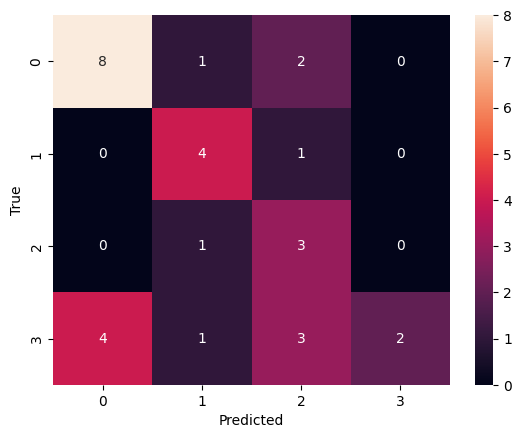

In [13]:
cm = confusion_matrix(y_test, predictions)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

this confusion matrix provides a snapshot of the model predictive performance across different glioblastoma mutation types. Clinically, the aim would be to maximize the true positives while minimizing the false positives and negatives, thereby ensuring that patients receive the most appropriate, personalized treatment based on their tumor's genetic makeup. Improving this model's accuracy and understanding its limitations are crucial steps toward integrating radiogenomics into routine clinical decision-making for glioblastoma patients.

In [14]:
y_score = model.decision_function(X_test)
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = 4  # Number of classes
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test == i, y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

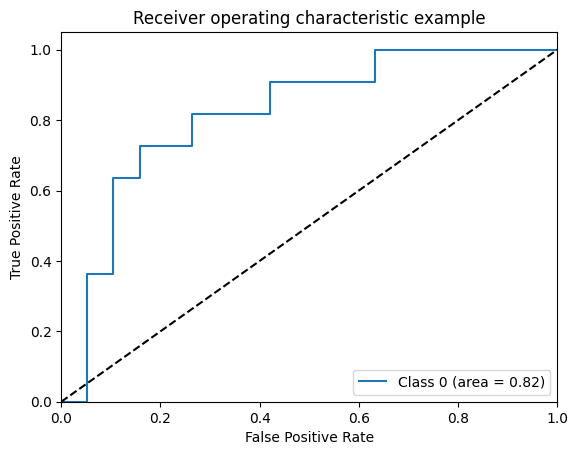

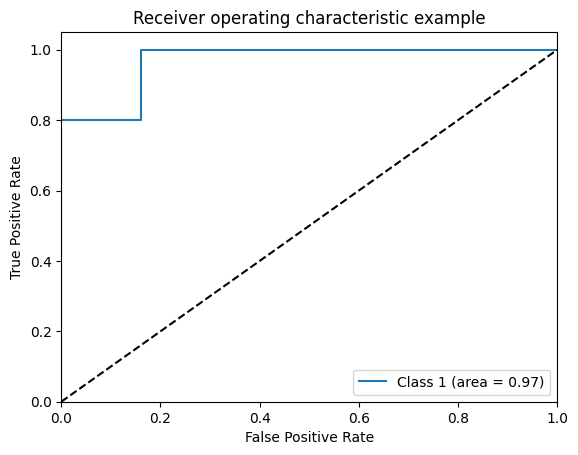

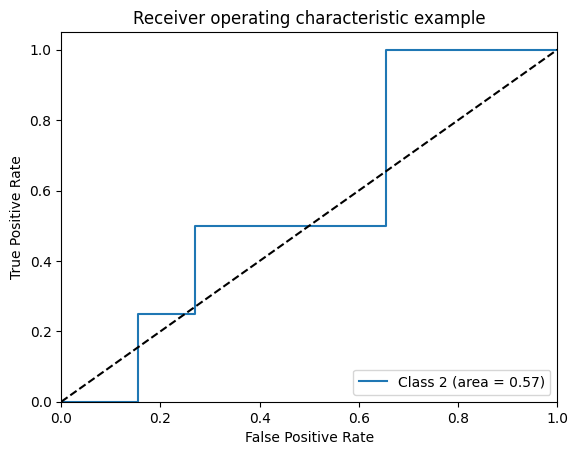

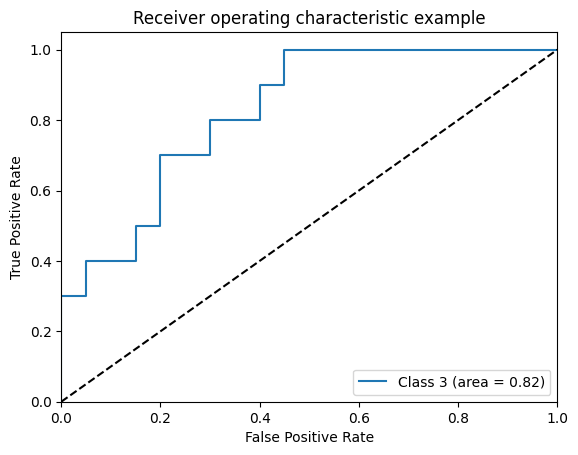

In [15]:
for i in range(n_classes):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (area = {roc_auc[i]:0.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()